In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pathlib import Path

PROJECT_ROOT = Path("E:/EpiSight")
PROCESSED_DATA = PROJECT_ROOT / "data" / "processed"

# Chargement des données nettoyées
tests    = pd.read_csv(PROCESSED_DATA / "tests_clean.csv", parse_dates=['jour'])
hosp     = pd.read_csv(PROCESSED_DATA / "hospitalisations_clean.csv", parse_dates=['jour'])
vacc     = pd.read_csv(PROCESSED_DATA / "vaccination_clean.csv", parse_dates=['jour'])
tests_nat = pd.read_csv(PROCESSED_DATA / "tests_national.csv", parse_dates=['jour'])
hosp_nat  = pd.read_csv(PROCESSED_DATA / "hospitalisations_national.csv", parse_dates=['jour'])

print("Données chargées")
print(f"   Tests par département  : {len(tests):,} lignes")
print(f"   Hospitalisations       : {len(hosp):,} lignes")
print(f"   Vaccination            : {len(vacc):,} lignes")

Données chargées
   Tests par département  : 118,626 lignes
   Hospitalisations       : 113,118 lignes
   Vaccination            : 95,378 lignes


C:\Users\user\AppData\Local\Temp\ipykernel_13240\2291391413.py:13: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  vacc     = pd.read_csv(PROCESSED_DATA / "vaccination_clean.csv", parse_dates=['jour'])


In [2]:
print("CALCUL — TAUX D'INCIDENCE PAR DÉPARTEMENT")
print("=" * 50)

# Taux d'incidence standard = cas sur 7 jours glissants pour 100 000 habitants
# Indicateur Officiel pour alertes préfectorales

# Tri chronologique/département
tests = tests.sort_values(['dep', 'jour']).reset_index(drop=True)

# Calcul des cas cumulés sur 7 jours glissants/département
tests['cas_7j'] = (
    tests.groupby('dep')['cas_positifs']
    .transform(lambda x: x.rolling(7, min_periods=1).sum())
)

# Taux d'incidence pour 100 000 habitants
tests['taux_incidence'] = (
    tests['cas_7j'] / tests['population'] * 100_000
).round(1)

# Vérification sur un département (ex: Paris = 75)
paris = tests[tests['dep'] == '75'].tail(10)
print(f"\nDépartement 75 (Paris) — 10 derniers jours :")
print(paris[['jour','cas_positifs','cas_7j','population','taux_incidence']].to_string())

# Seuils officiels SPF
print("\nSeuils de taux d'incidence :")
print("   < 10   → Circulation faible")
print("   10-50  → Circulation modérée") 
print("   50-150 → Circulation active")
print("   > 150  → Alerte")
print("   > 250  → Alerte renforcée")

CALCUL — TAUX D'INCIDENCE PAR DÉPARTEMENT

Département 75 (Paris) — 10 derniers jours :
            jour  cas_positifs  cas_7j  population  taux_incidence
86706 2023-06-18          16.0   372.0   2139907.0            17.4
86707 2023-06-19          75.0   337.0   2139907.0            15.7
86708 2023-06-20          51.0   335.0   2139907.0            15.7
86709 2023-06-21          50.0   324.0   2139907.0            15.1
86710 2023-06-22          39.0   310.0   2139907.0            14.5
86711 2023-06-23          40.0   297.0   2139907.0            13.9
86712 2023-06-24          28.0   299.0   2139907.0            14.0
86713 2023-06-25          13.0   296.0   2139907.0            13.8
86714 2023-06-26          69.0   290.0   2139907.0            13.6
86715 2023-06-27          48.0   287.0   2139907.0            13.4

Seuils de taux d'incidence :
   < 10   → Circulation faible
   10-50  → Circulation modérée
   50-150 → Circulation active
   > 150  → Alerte
   > 250  → Alerte renforcée


In [3]:
print("DÉTECTION DES VAGUES ÉPIDÉMIQUES")
print("=" * 50)

# Algorithme simple :
# Une vague = période où la MM7 des cas dépasse un seuil
# pendant au moins 14 jours consécutifs

SEUIL_VAGUE = 10_000  # cas/jour au niveau national

tests_nat_sorted = tests_nat.sort_values('jour').copy()

# Identifie les jours au-dessus du seuil
tests_nat_sorted['en_vague'] = tests_nat_sorted['cas_mm7'] > SEUIL_VAGUE

# Numérote les groupes consécutifs
tests_nat_sorted['groupe'] = (
    tests_nat_sorted['en_vague'] != tests_nat_sorted['en_vague'].shift()
).cumsum()

# Extraction uniquement des périodes de vague (en_vague == True)
vagues = (
    tests_nat_sorted[tests_nat_sorted['en_vague']]
    .groupby('groupe')
    .agg(
        debut=('jour', 'min'),
        fin=('jour', 'max'),
        pic_cas=('cas_mm7', 'max')
    )
    .reset_index(drop=True)
)

# Filtrer les vagues de moins de 14 jours (bruit)
vagues['duree_jours'] = (vagues['fin'] - vagues['debut']).dt.days
vagues = vagues[vagues['duree_jours'] >= 14].reset_index(drop=True)
vagues.index += 1  # Numérotation à partir de 1

print(f"\n{len(vagues)} vagues détectées :\n")
print(vagues[['debut','fin','duree_jours','pic_cas']].to_string())

DÉTECTION DES VAGUES ÉPIDÉMIQUES

3 vagues détectées :

       debut        fin  duree_jours   pic_cas
1 2020-09-30 2021-05-23          235   47779.0
2 2021-07-19 2021-09-09           52   23534.0
3 2021-11-13 2023-01-08          421  354350.0


In [4]:
print("INDICATEURS HOSPITALIERS")
print("=" * 50)

hosp_nat_sorted = hosp_nat.sort_values('jour').copy()

# Taux d'occupation des lits de réanimation
# Population française, environ 68 millions;
# capacité rea normale ≈ 5 000 lits
CAPACITE_REA_NORMALE = 5_000

hosp_nat_sorted['taux_occupation_rea'] = (
    hosp_nat_sorted['reanimation'] / CAPACITE_REA_NORMALE * 100
).round(1)

# Nouveaux décès quotidiens (différence entre jours consécutifs)
# dc dans le dataset = total cumulé depuis le début
hosp_nat_sorted['nouveaux_deces'] = hosp_nat_sorted['deces'].diff().clip(lower=0)
hosp_nat_sorted['deces_mm7'] = (
    hosp_nat_sorted['nouveaux_deces'].rolling(7, min_periods=1).mean().round(1)
)

# Pic de réanimation
pic_rea = hosp_nat_sorted.loc[hosp_nat_sorted['reanimation'].idxmax()]
print(f"\nPic de réanimation :")
print(f"   Date  : {pic_rea['jour'].date()}")
print(f"   Patients en réa : {int(pic_rea['reanimation']):,}")
print(f"   Taux occupation : {pic_rea['taux_occupation_rea']}%")

# Pic d'hospitalisations  
pic_hosp = hosp_nat_sorted.loc[hosp_nat_sorted['hospitalises'].idxmax()]
print(f"\nPic d'hospitalisations :")
print(f"   Date  : {pic_hosp['jour'].date()}")
print(f"   Patients hospitalisés : {int(pic_hosp['hospitalises']):,}")

print(f"\nAperçu 5 derniers jours :")
cols_affich = ['jour','hospitalises','reanimation','taux_occupation_rea','deces_mm7']
print(hosp_nat_sorted[cols_affich].tail(5).to_string())

INDICATEURS HOSPITALIERS

Pic de réanimation :
   Date  : 2020-04-08
   Patients en réa : 7,019
   Taux occupation : 140.4%

Pic d'hospitalisations :
   Date  : 2020-11-16
   Patients hospitalisés : 33,466

Aperçu 5 derniers jours :
           jour  hospitalises  reanimation  taux_occupation_rea  deces_mm7
1104 2023-03-27         13113          728                 14.6       21.3
1105 2023-03-28         13178          720                 14.4       21.9
1106 2023-03-29         13184          734                 14.7       24.9
1107 2023-03-30         13186          732                 14.6       26.4
1108 2023-03-31         13149          709                 14.2       28.7


In [5]:
print("INDICATEURS VACCINATION")
print("=" * 50)

# Agrégation nationale
vacc_nat = (
    vacc.groupby('jour')
    .agg(
        doses_jour=('n_dose1', 'sum'),
        complet_jour=('n_complet', 'sum'),
        cum_dose1=('n_cum_dose1', 'sum'),
        cum_complet=('n_cum_complet', 'sum'),
        cum_rappel=('n_cum_rappel', 'sum')
    )
    .reset_index()
    .sort_values('jour')
)

# Couverture vaccinale nationale
# Population France métropolitaine + DOM, environ 68 millions
POP_FRANCE = 68_000_000

vacc_nat['couv_dose1_pct']   = (vacc_nat['cum_dose1']   / POP_FRANCE * 100).round(1)
vacc_nat['couv_complet_pct'] = (vacc_nat['cum_complet'] / POP_FRANCE * 100).round(1)
vacc_nat['couv_rappel_pct']  = (vacc_nat['cum_rappel']  / POP_FRANCE * 100).round(1)

# Pic de vaccination journalière
pic_vacc = vacc_nat.loc[vacc_nat['doses_jour'].idxmax()]
print(f"\nPic de vaccination journalière :")
print(f"   Date   : {pic_vacc['jour'].date()}")
print(f"   Doses  : {int(pic_vacc['doses_jour']):,}")

# Couverture finale atteinte
derniere_ligne = vacc_nat.iloc[-1]
print(f"\nCouverture vaccinale finale ({derniere_ligne['jour'].date()}) :")
print(f"   Au moins 1 dose  : {derniere_ligne['couv_dose1_pct']}%")
print(f"   Schéma complet   : {derniere_ligne['couv_complet_pct']}%")
print(f"   Rappel           : {derniere_ligne['couv_rappel_pct']}%")

INDICATEURS VACCINATION

Pic de vaccination journalière :
   Date   : 2021-05-20
   Doses  : 495,997

Couverture vaccinale finale (2023-07-10) :
   Au moins 1 dose  : 77.5%
   Schéma complet   : 76.6%
   Rappel           : 59.4%


In [6]:
print("TABLEAU DE BORD — INDICATEURS CLÉS")
print("=" * 50)

# Dernières valeurs disponibles
derniers_tests = tests_nat.sort_values('jour').iloc[-1]
derniers_hosp  = hosp_nat_sorted.iloc[-1]
derniere_vacc  = vacc_nat.iloc[-1]

kpis = {
    "Période analysée": f"{tests_nat['jour'].min().date()} → {tests_nat['jour'].max().date()}",
    "Cas positifs total": f"{int(tests_nat['cas_positifs'].sum()):,}",
    "Tests réalisés total": f"{int(tests_nat['total_tests'].sum()):,}",
    "Pic de cas (MM7)": f"{int(tests_nat['cas_mm7'].max()):,} cas/jour",
    "Pic hospitalisations": f"{int(hosp_nat['hospitalises'].max()):,} patients",
    "Pic réanimation": f"{int(hosp_nat['reanimation'].max()):,} patients",
    "Vagues détectées": len(vagues),
    "Couverture vaccinale (complet)": f"{derniere_vacc['couv_complet_pct']}%",
}

for indicateur, valeur in kpis.items():
    print(f"   {indicateur:<35} : {valeur}")

TABLEAU DE BORD — INDICATEURS CLÉS
   Période analysée                    : 2020-05-13 → 2023-06-27
   Cas positifs total                  : 38,673,066
   Tests réalisés total                : 313,405,199
   Pic de cas (MM7)                    : 354,350 cas/jour
   Pic hospitalisations                : 33,466 patients
   Pic réanimation                     : 7,019 patients
   Vagues détectées                    : 3
   Couverture vaccinale (complet)      : 76.6%


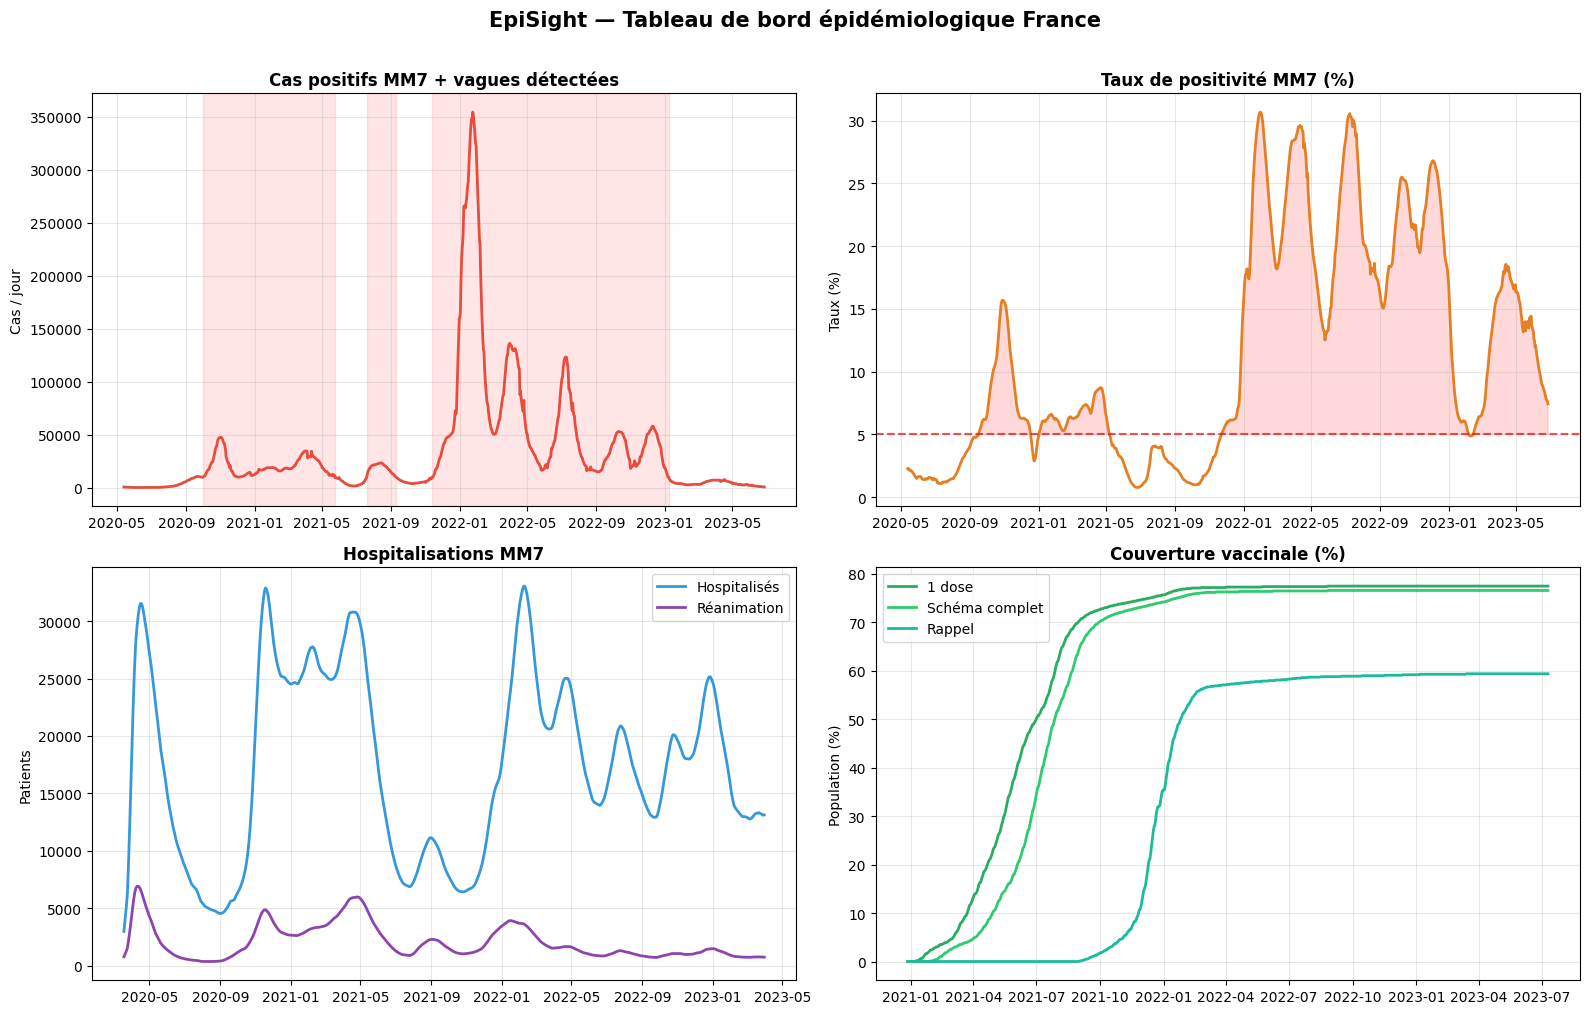

Tableau de bord sauvegardé


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('EpiSight — Tableau de bord épidémiologique France', 
             fontsize=15, fontweight='bold', y=1.01)

# Graphique 1 : Cas + vagues détectées
ax = axes[0, 0]
ax.plot(tests_nat_sorted['jour'], tests_nat_sorted['cas_mm7'], 
        color='#e74c3c', linewidth=2)
for _, vague in vagues.iterrows():
    ax.axvspan(vague['debut'], vague['fin'], alpha=0.1, color='red')
ax.set_title('Cas positifs MM7 + vagues détectées', fontweight='bold')
ax.set_ylabel('Cas / jour')
ax.grid(True, alpha=0.3)

# Graphique 2 : Taux de positivité
ax = axes[0, 1]
ax.plot(tests_nat_sorted['jour'], tests_nat_sorted['tp_mm7'], 
        color='#e67e22', linewidth=2)
ax.axhline(y=5, color='red', linestyle='--', alpha=0.7)
ax.fill_between(tests_nat_sorted['jour'], tests_nat_sorted['tp_mm7'], 5,
                where=tests_nat_sorted['tp_mm7'] > 5,
                alpha=0.15, color='red')
ax.set_title('Taux de positivité MM7 (%)', fontweight='bold')
ax.set_ylabel('Taux (%)')
ax.grid(True, alpha=0.3)

# Graphique 3 : Hospitalisations
ax = axes[1, 0]
ax.plot(hosp_nat_sorted['jour'], hosp_nat_sorted['hosp_mm7'],
        color='#3498db', linewidth=2, label='Hospitalisés')
ax.plot(hosp_nat_sorted['jour'], hosp_nat_sorted['rea_mm7'],
        color='#8e44ad', linewidth=2, label='Réanimation')
ax.set_title('Hospitalisations MM7', fontweight='bold')
ax.set_ylabel('Patients')
ax.legend()
ax.grid(True, alpha=0.3)

# Graphique 4 : Couverture vaccinale
ax = axes[1, 1]
ax.plot(vacc_nat['jour'], vacc_nat['couv_dose1_pct'],
        color='#27ae60', linewidth=2, label='1 dose')
ax.plot(vacc_nat['jour'], vacc_nat['couv_complet_pct'],
        color='#2ecc71', linewidth=2, label='Schéma complet')
ax.plot(vacc_nat['jour'], vacc_nat['couv_rappel_pct'],
        color='#1abc9c', linewidth=2, label='Rappel')
ax.set_title('Couverture vaccinale (%)', fontweight='bold')
ax.set_ylabel('Population (%)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PROJECT_ROOT / "assets" / "tableau_bord_indicateurs.png", 
            dpi=150, bbox_inches='tight')
plt.show()
print("Tableau de bord sauvegardé")

In [8]:
# Sauvegarder les datasets enrichis pour le dashboard Streamlit
tests_nat_sorted.to_csv(PROCESSED_DATA / "indicateurs_tests.csv", index=False)
hosp_nat_sorted.to_csv(PROCESSED_DATA  / "indicateurs_hosp.csv", index=False)
vacc_nat.to_csv(PROCESSED_DATA         / "indicateurs_vacc.csv", index=False)
tests.to_csv(PROCESSED_DATA            / "tests_par_dep.csv", index=False)
vagues.to_csv(PROCESSED_DATA           / "vagues_detectees.csv", index=False)

print("Fichiers indicateurs sauvegardés :")
for f in sorted(PROCESSED_DATA.iterdir()):
    taille = f.stat().st_size / (1024 * 1024)
    print(f"   {f.name:<45} ({taille:.1f} Mo)")

Fichiers indicateurs sauvegardés :
   hospitalisations_clean.csv                    (3.2 Mo)
   hospitalisations_national.csv                 (0.0 Mo)
   indicateurs_hosp.csv                          (0.1 Mo)
   indicateurs_tests.csv                         (0.1 Mo)
   indicateurs_vacc.csv                          (0.1 Mo)
   tests_clean.csv                               (4.7 Mo)
   tests_national.csv                            (0.1 Mo)
   tests_par_dep.csv                             (6.0 Mo)
   vaccination_clean.csv                         (5.2 Mo)
   vagues_detectees.csv                          (0.0 Mo)
